In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch 
import sys

# N-hop Eff&Pur

In [ ]:
import scipy as sp
import numpy as np
from scipy import sparse
def efficiency_performance_wrt_distance(gnn_graph, pred_graph, truth_graph, n_hop):
    
    array_size = max(gnn_graph.max().item(), pred_graph.max().item(), truth_graph.max().item()) + 1

    if torch.is_tensor(pred_graph):
        l1 = pred_graph.cpu().numpy()
    else:
        l1 = pred_graph
    if torch.is_tensor(truth_graph):
        l2 = truth_graph.cpu().numpy()
    else:
        l2 = truth_graph
    if torch.is_tensor(gnn_graph):
        l3 = gnn_graph.cpu().numpy()
    else:
        l3 = gnn_graph
        
    e_pred = sp.sparse.coo_matrix(
        (np.ones(l1.shape[1]), l1), shape=(array_size, array_size)
    ).tocsr()
    e_truth = sp.sparse.coo_matrix(
        (np.ones(l2.shape[1]), l2), shape=(array_size, array_size)
    ).tocsr()
    e_gnn = sp.sparse.coo_matrix(
        (np.ones(l3.shape[1]), l3), shape=(array_size, array_size)
    ).tocsr()
    
    # symmetrization:
    e_pred = ((e_pred + e_pred.T) > 0).astype(np.float32)
    e_truth = ((e_truth + e_truth.T) > 0).astype(np.float32)
    e_gnn = ((e_gnn + e_gnn.T) > 0).astype(np.float32)
    
    # find n hop neighbors
    
    n_hop_neighbors = []
    
    for i in range(n_hop):
        power = e_gnn
        for j in range(i):
            power = power @ e_gnn
        power = power > 0
        n_hop_neighbors.append(power.astype(np.float32))
        del power
    
    for i in reversed(range(n_hop)):
        for j in reversed(range(i)):
            n_hop_neighbors[i] = n_hop_neighbors[i] - n_hop_neighbors[j]
        n_hop_neighbors[i] = (n_hop_neighbors[i] > 0).astype(np.float32)
    
    n_hop_eff = []
    
    for i in range(n_hop):
        signal_num = e_truth.multiply(n_hop_neighbors[i]).sum()
        found_num = e_truth.multiply(e_pred.multiply(n_hop_neighbors[i])).sum()
        n_hop_eff.append((found_num/(signal_num + 1e-12), int(found_num/2), int(signal_num/2)))
        
    return n_hop_eff, n_hop_neighbors

In [2]:
path = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/"
event = torch.load(path + "test/0008", map_location = "cpu")

In [ ]:
torch.unique(event.pid, return_inverse = True)[1].max()

In [3]:
event

Data(x=[100811, 3], cell_data=[100811, 11], pid=[100811], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010008', hid=[100811], pt=[100811], primary=[100811], nhits=[100811], modulewise_true_edges=[2, 40061], signal_true_edges=[2, 6154], edge_index=[2, 437381], y=[437381], pedigree=[1], y_pid=[437381], pid_signal=[437381], scores=[437381])

In [ ]:
pred_graph = event.edge_index[:,event.scores > 0.0]
gnn_graph = event.edge_index[:,(event.scores > 0.15) | (torch.rand(event.scores.shape) < 0.1)]
signal_graph = event.signal_true_edges
# n_hop_eff, n_hop_neighbors = efficiency_performance_wrt_distance(gnn_graph, pred_graph, signal_graph, 10)
# print(n_hop_eff)
# print(*[n_hop_neighbors[i].sum() for i in range(len(n_hop_neighbors))])

In [ ]:
uniques, inverse = event.pid[(event.pt > 1000.) & (event.primary == 1) & (event.nhits >= 3)].unique(return_inverse = True)
print(inverse.max())

In [ ]:
mask = torch.tensor(len(event.pid) * [False])
conncted_nodes = torch.unique(event.edge_index[:,event.scores > 0.15])
mask[conncted_nodes] = True

inverse_mask = torch.zeros(len(event.pid)).long()
inverse_mask[mask] = torch.arange(mask.sum())

In [ ]:
pred_graph = pred_graph[:, mask[pred_graph].all(0)]
pred_graph = inverse_mask[pred_graph]

In [ ]:
from scipy.sparse.csgraph import connected_components

graph = sp.sparse.coo_matrix((np.ones(pred_graph.shape[1]), pred_graph), shape=(pred_graph.max()+1, pred_graph.max()+1)).tocsr()
n_components, labels = connected_components(graph, directed=False, return_labels=True)
print(n_components, labels)
# print(pred_graph.unique(return_inverse = True)[1])

In [ ]:
score_cut = 0.5
eff = event.y[event.scores > score_cut].sum()/event.signal_true_edges.shape[1]
pur = event.y[event.scores > score_cut].sum()/(event.scores > score_cut).sum()
print("eff:{:.3f}, pur:{:.3f}".format(eff.item(), pur.item()))

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn import svm
RocCurveDisplay.from_predictions(event.y.bool().numpy(), event.scores.numpy())

# Toy Model

In [ ]:
import torch 
import sys
from torch_geometric.data import Data
from scipy.sparse.csgraph import connected_components
import scipy as sp
import numpy as np
from scipy import sparse
def generate_toys(num_tracks, num_layers, min_r, max_r, detector_width, ptcut, eff, pur):
    # pT is defined as 1000r
    
    tracks = []
    for i in range(num_tracks):
        r = np.random.uniform(min_r, max_r)
        theta = np.random.uniform(0, np.pi)
        sign = np.random.choice([-1, 1])

        x = np.linspace(0.05, detector_width + 0.05, num = num_layers)
        y = sign*(np.sqrt(r**2 - (x - r*np.cos(theta))**2) - r*np.sin(theta))
        pid = np.array(len(x)*[i+1], dtype = np.int64)
        pt = 1000 * np.array(len(x)*[r])
        
        mask = (y == y)
        x, y, pid, pt = x[mask], y[mask], pid[mask], pt[mask]
        
        tracks.append(np.vstack([x, y, pid, pt]).T)
    
    node_feature = np.concatenate(tracks, axis = 0)
    
    connections = (node_feature[1:, 2] == node_feature[:-1,2])

    idxs = np.arange(len(node_feature))

    truth_graph = np.vstack([idxs[:-1][connections], idxs[1:][connections]])
    signal_true_graph = truth_graph[:, (node_feature[:, 3][truth_graph] > ptcut).all(0)]
    
    fully_connected_graph = np.vstack([np.resize(idxs, (len(idxs),len(idxs))).flatten(), np.resize(idxs, (len(idxs),len(idxs))).T.flatten()])
    del_x = (node_feature[fully_connected_graph[1], 0] - node_feature[fully_connected_graph[0], 0])
    del_y = np.abs((node_feature[fully_connected_graph[0], 1] - node_feature[fully_connected_graph[1], 1]))
    fully_connected_graph = fully_connected_graph[:, (del_x <= 2*detector_width/num_layers) & (del_x > 0) & (del_y<0.4)]
    fully_connected_graph = fully_connected_graph[:, fully_connected_graph[0] != fully_connected_graph[1]]

    truth_graph_samples = signal_true_graph[:, np.random.random_sample(size=signal_true_graph.shape[1]) < eff]
    fake_graph_samples = fully_connected_graph[:, np.random.random_sample(size=fully_connected_graph.shape[1]) <=(1-pur)/pur*eff*truth_graph_samples.shape[1]/fully_connected_graph.shape[1]]

    graph = np.concatenate([truth_graph_samples, fake_graph_samples], axis = 1)
    
    new_graph, y = graph_intersection(graph, signal_true_graph)
    
    y_pid = (node_feature[:,2][new_graph[0]] == node_feature[:,2][new_graph[1]])
    pid_signal = (node_feature[:,2][new_graph[0]] == node_feature[:,2][new_graph[1]]) & (node_feature[:,3][new_graph]).all(0)
    node_feature = torch.tensor(node_feature)
    
    event = Data(x=node_feature[:,0:2],
                 edge_index= new_graph,
                 graph = new_graph,
                 modulewise_true_edges = torch.tensor(truth_graph),
                 signal_true_edges = torch.tensor(signal_true_graph),
                 y=y,
                 pt = node_feature[:,3],
                 pid = node_feature[:,2].long(),
                 y_pid = y_pid,
                 pid_signal = pid_signal,
                )
    
    graph = sp.sparse.coo_matrix((np.ones(new_graph.cpu().shape[1]), new_graph.cpu()), shape=(new_graph.cpu().max()+1, new_graph.cpu().max()+1)
                                ).tocsr()
    _, labels = connected_components(graph, directed=False, return_labels=True)

    labels = torch.tensor(labels).long()

    event.assignment_init = torch.nn.functional.one_hot(labels % 1000, num_classes= 1000).float()
    
    return event
    
def graph_intersection(
    pred_graph, truth_graph, using_weights=False, weights_bidir=None
):

    array_size = max(pred_graph.max().item(), truth_graph.max().item()) + 1

    if torch.is_tensor(pred_graph):
        l1 = pred_graph.cpu().numpy()
    else:
        l1 = pred_graph
    if torch.is_tensor(truth_graph):
        l2 = truth_graph.cpu().numpy()
    else:
        l2 = truth_graph
    e_1 = sp.sparse.coo_matrix(
        (np.ones(l1.shape[1]), l1), shape=(array_size, array_size)
    ).tocsr()
    e_2 = sp.sparse.coo_matrix(
        (np.ones(l2.shape[1]), l2), shape=(array_size, array_size)
    ).tocsr()
    del l1

    e_intersection = e_1.multiply(e_2) - ((e_1 - e_2) > 0)
    del e_1
    del e_2

    if using_weights:
        weights_list = weights_bidir.cpu().numpy()
        weights_sparse = sp.sparse.coo_matrix(
            (weights_list, l2), shape=(array_size, array_size)
        ).tocsr()
        del weights_list
        del l2
        new_weights = weights_sparse[e_intersection.astype("bool")]
        del weights_sparse
        new_weights = torch.from_numpy(np.array(new_weights)[0])

    e_intersection = e_intersection.tocoo()
    new_pred_graph = torch.from_numpy(
        np.vstack([e_intersection.row, e_intersection.col])
    ).long()  # .to(device)
    y = torch.from_numpy(e_intersection.data > 0)  # .to(device)
    del e_intersection

    if using_weights:
        return new_pred_graph, y, new_weights
    else:
        return new_pred_graph, y

In [ ]:
event = generate_toys(100, 10, 1, 5, 2, 1000., 0.9, 0.5)

In [ ]:
del_y = (event.x[event.signal_true_edges[0], 1] - event.x[event.signal_true_edges[1], 1])
x = (event.x[event.signal_true_edges[0], 0] + event.x[event.signal_true_edges[1], 0])/2
print((del_y).abs().mean())
print((del_y).square().mean().sqrt())
print(del_y.abs().max())

In [ ]:
import networkx as nx
from matplotlib import cm

G = nx.Graph()
G.add_nodes_from(range(len(event.x)))

for i in range(len(event.graph.T)):
    color = "red" if event.y[i] else "gray" 
    G.add_edge(*event.graph.T.tolist()[i], color = color)

pos = {}

for i in range(len(event.x)):
    pos[i] = event.x[i].numpy()
    
node_color = cm.jet(event.pid/event.pid.max())

import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
nx.draw(G, pos=pos, node_size = 100, node_color = node_color, edge_color = nx.get_edge_attributes(G,'color').values())
plt.draw()

In [ ]:
batch = event

unnormalized_assignment = torch.rand((len(batch.pid), 10))
assignments = torch.nn.Softmax(dim = -1)(unnormalized_assignment)

In [ ]:
from torch_scatter import scatter_mean, scatter_add, scatter_min
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
from torch import nn
_, pid = torch.unique(batch.pid.long(), return_inverse = True)
pt = scatter_min(batch.pt, pid, dim=0, dim_size = pid.max()+1)[0]
matching = torch.zeros(pid.max()+1).long()

assignments = scatter_add(assignments, pid, dim = 0, dim_size = pid.max()+1)
probability = assignments/assignments.sum(1).unsqueeze(1)
signal_sample = (pt > 1000.)
inverse_mask = torch.arange(len(signal_sample))[signal_sample]

bipartite_graph = csr_matrix(probability[signal_sample].cpu().numpy())
row_match, col_match = min_weight_full_bipartite_matching(bipartite_graph, maximize=True)
matching[row_match] = torch.tensor(col_match).long()

if (~signal_sample).any():
    assignments[:,col_match] = -1
    matching[~signal_sample] = assignments[~signal_sample].argmax(1)

labels = matching[pid]
loss = nn.functional.cross_entropy(unnormalized_assignment, labels, reduction = "none")
print(batch.pid, signal_sample, pt, probability, labels, row_match, col_match, sep = "\n")
print(torch.stack([batch.pid, labels]).T)

weights = torch.rand(len(batch.pid))
weights = weights/weights.sum()

loss = torch.dot(loss, weights)

# HDBSCAN

In [1]:
import torch
import cudf
from cuml.neighbors import NearestNeighbors
from cuml.datasets import make_blobs
import cupy as cp
from cuml.cluster import HDBSCAN
import matplotlib.pyplot as plt



In [2]:
model = HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=0.0, metric='euclidean', gen_min_span_tree=True, cluster_selection_method = "leaf")

In [ ]:
%%time
import time
for i in range(1000):
    s = time.time()
    X, _ = make_blobs(n_samples=100000, centers=1000,
                        n_features=16, random_state=42)
    # build a cudf Dataframe
    clusters = model.fit_predict(X)
    print(time.time()-s)

Label prop iterations: 16
Label prop iterations: 6
Label prop iterations: 2
Iterations: 3
1074,98,437,12,158,764
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 3
Iterations: 4
455,106,439,10,191,694
0.8525078296661377
Label prop iterations: 16
Label prop iterations: 6
Label prop iterations: 2
Iterations: 3
1209,120,454,18,172,883
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 3
Iterations: 4
535,125,453,16,207,699
0.8380415439605713
Label prop iterations: 16
Label prop iterations: 6
Label prop iterations: 2
Iterations: 3
1014,127,447,20,182,899
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 3
Iterations: 4
728,130,453,17,208,708
0.8362805843353271
Label prop iterations: 16
Label prop iterations: 6
Label prop iterations: 2
Iterations: 3
1010,119,462,18,169,899
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 5
La

In [15]:
plt.figure(figsize=(8, 6), dpi= 500, facecolor='w', edgecolor='k')
model.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

RecursionError: maximum recursion depth exceeded while getting the str of an object

<Figure size 4000x3000 with 0 Axes>

<AxesSubplot:>

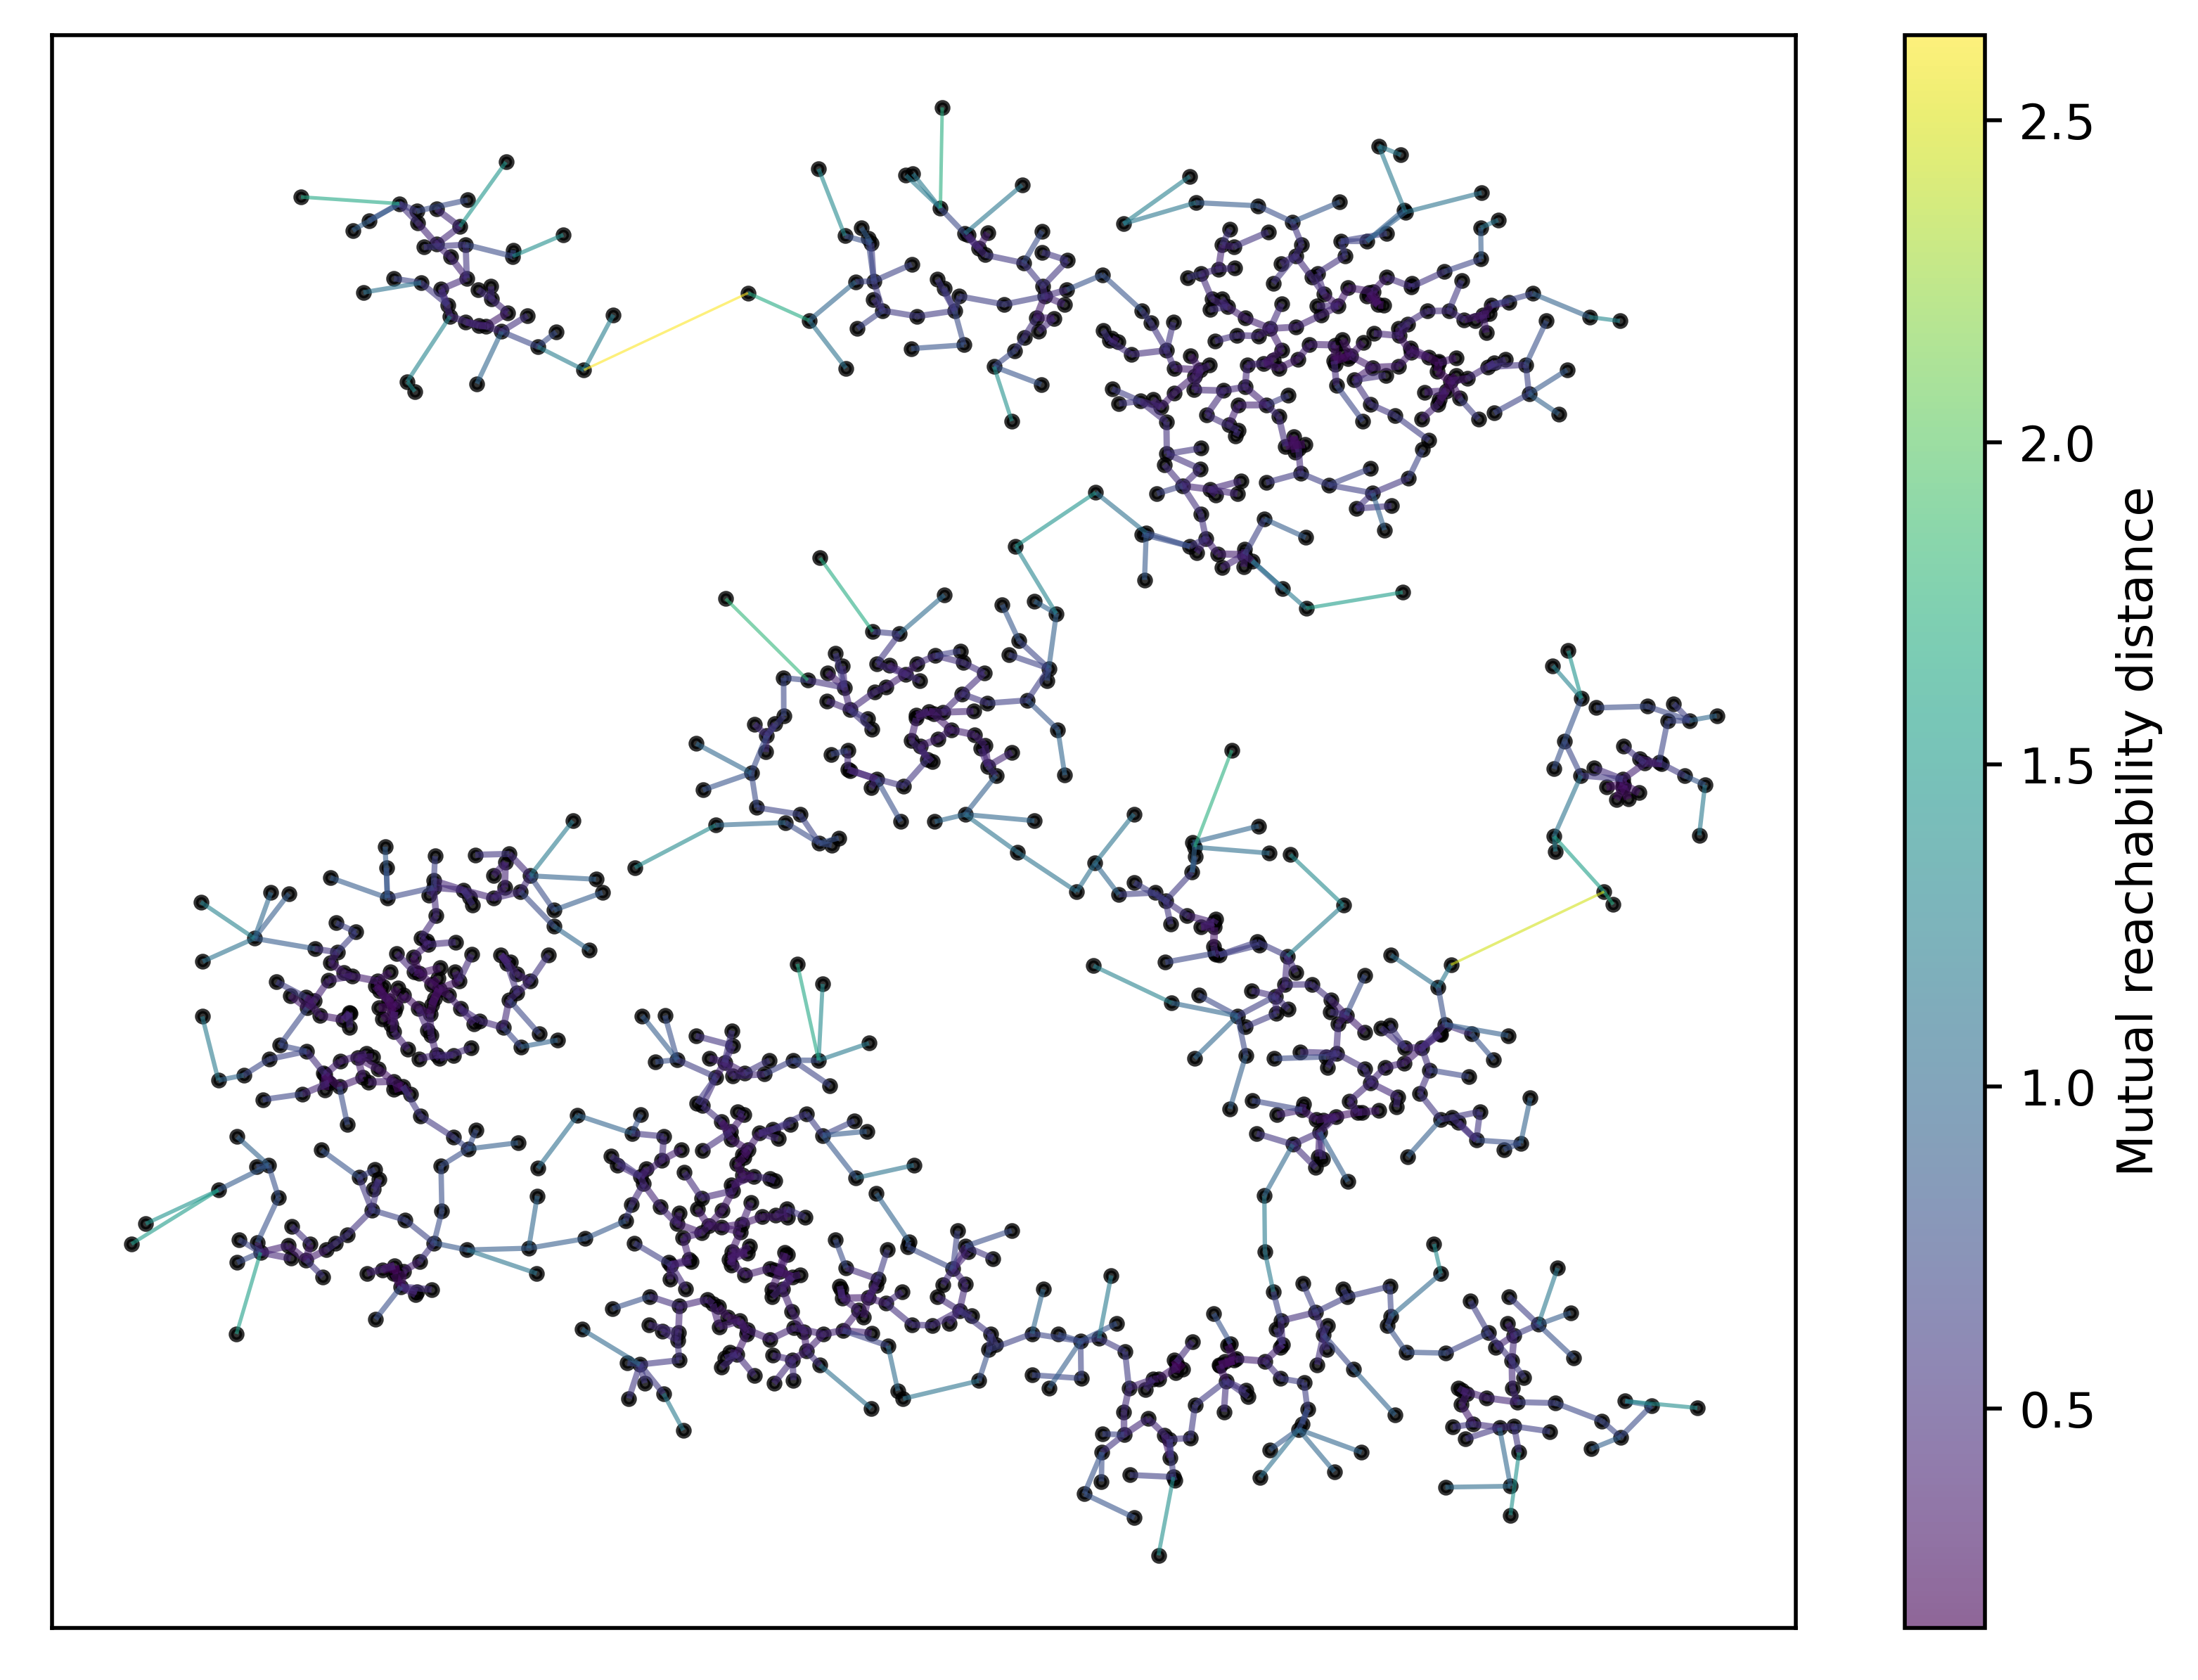

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi= 500, facecolor='w', edgecolor='k')
model.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=5,
                                      edge_linewidth=0.5)

<AxesSubplot:ylabel='$\\lambda$ value'>

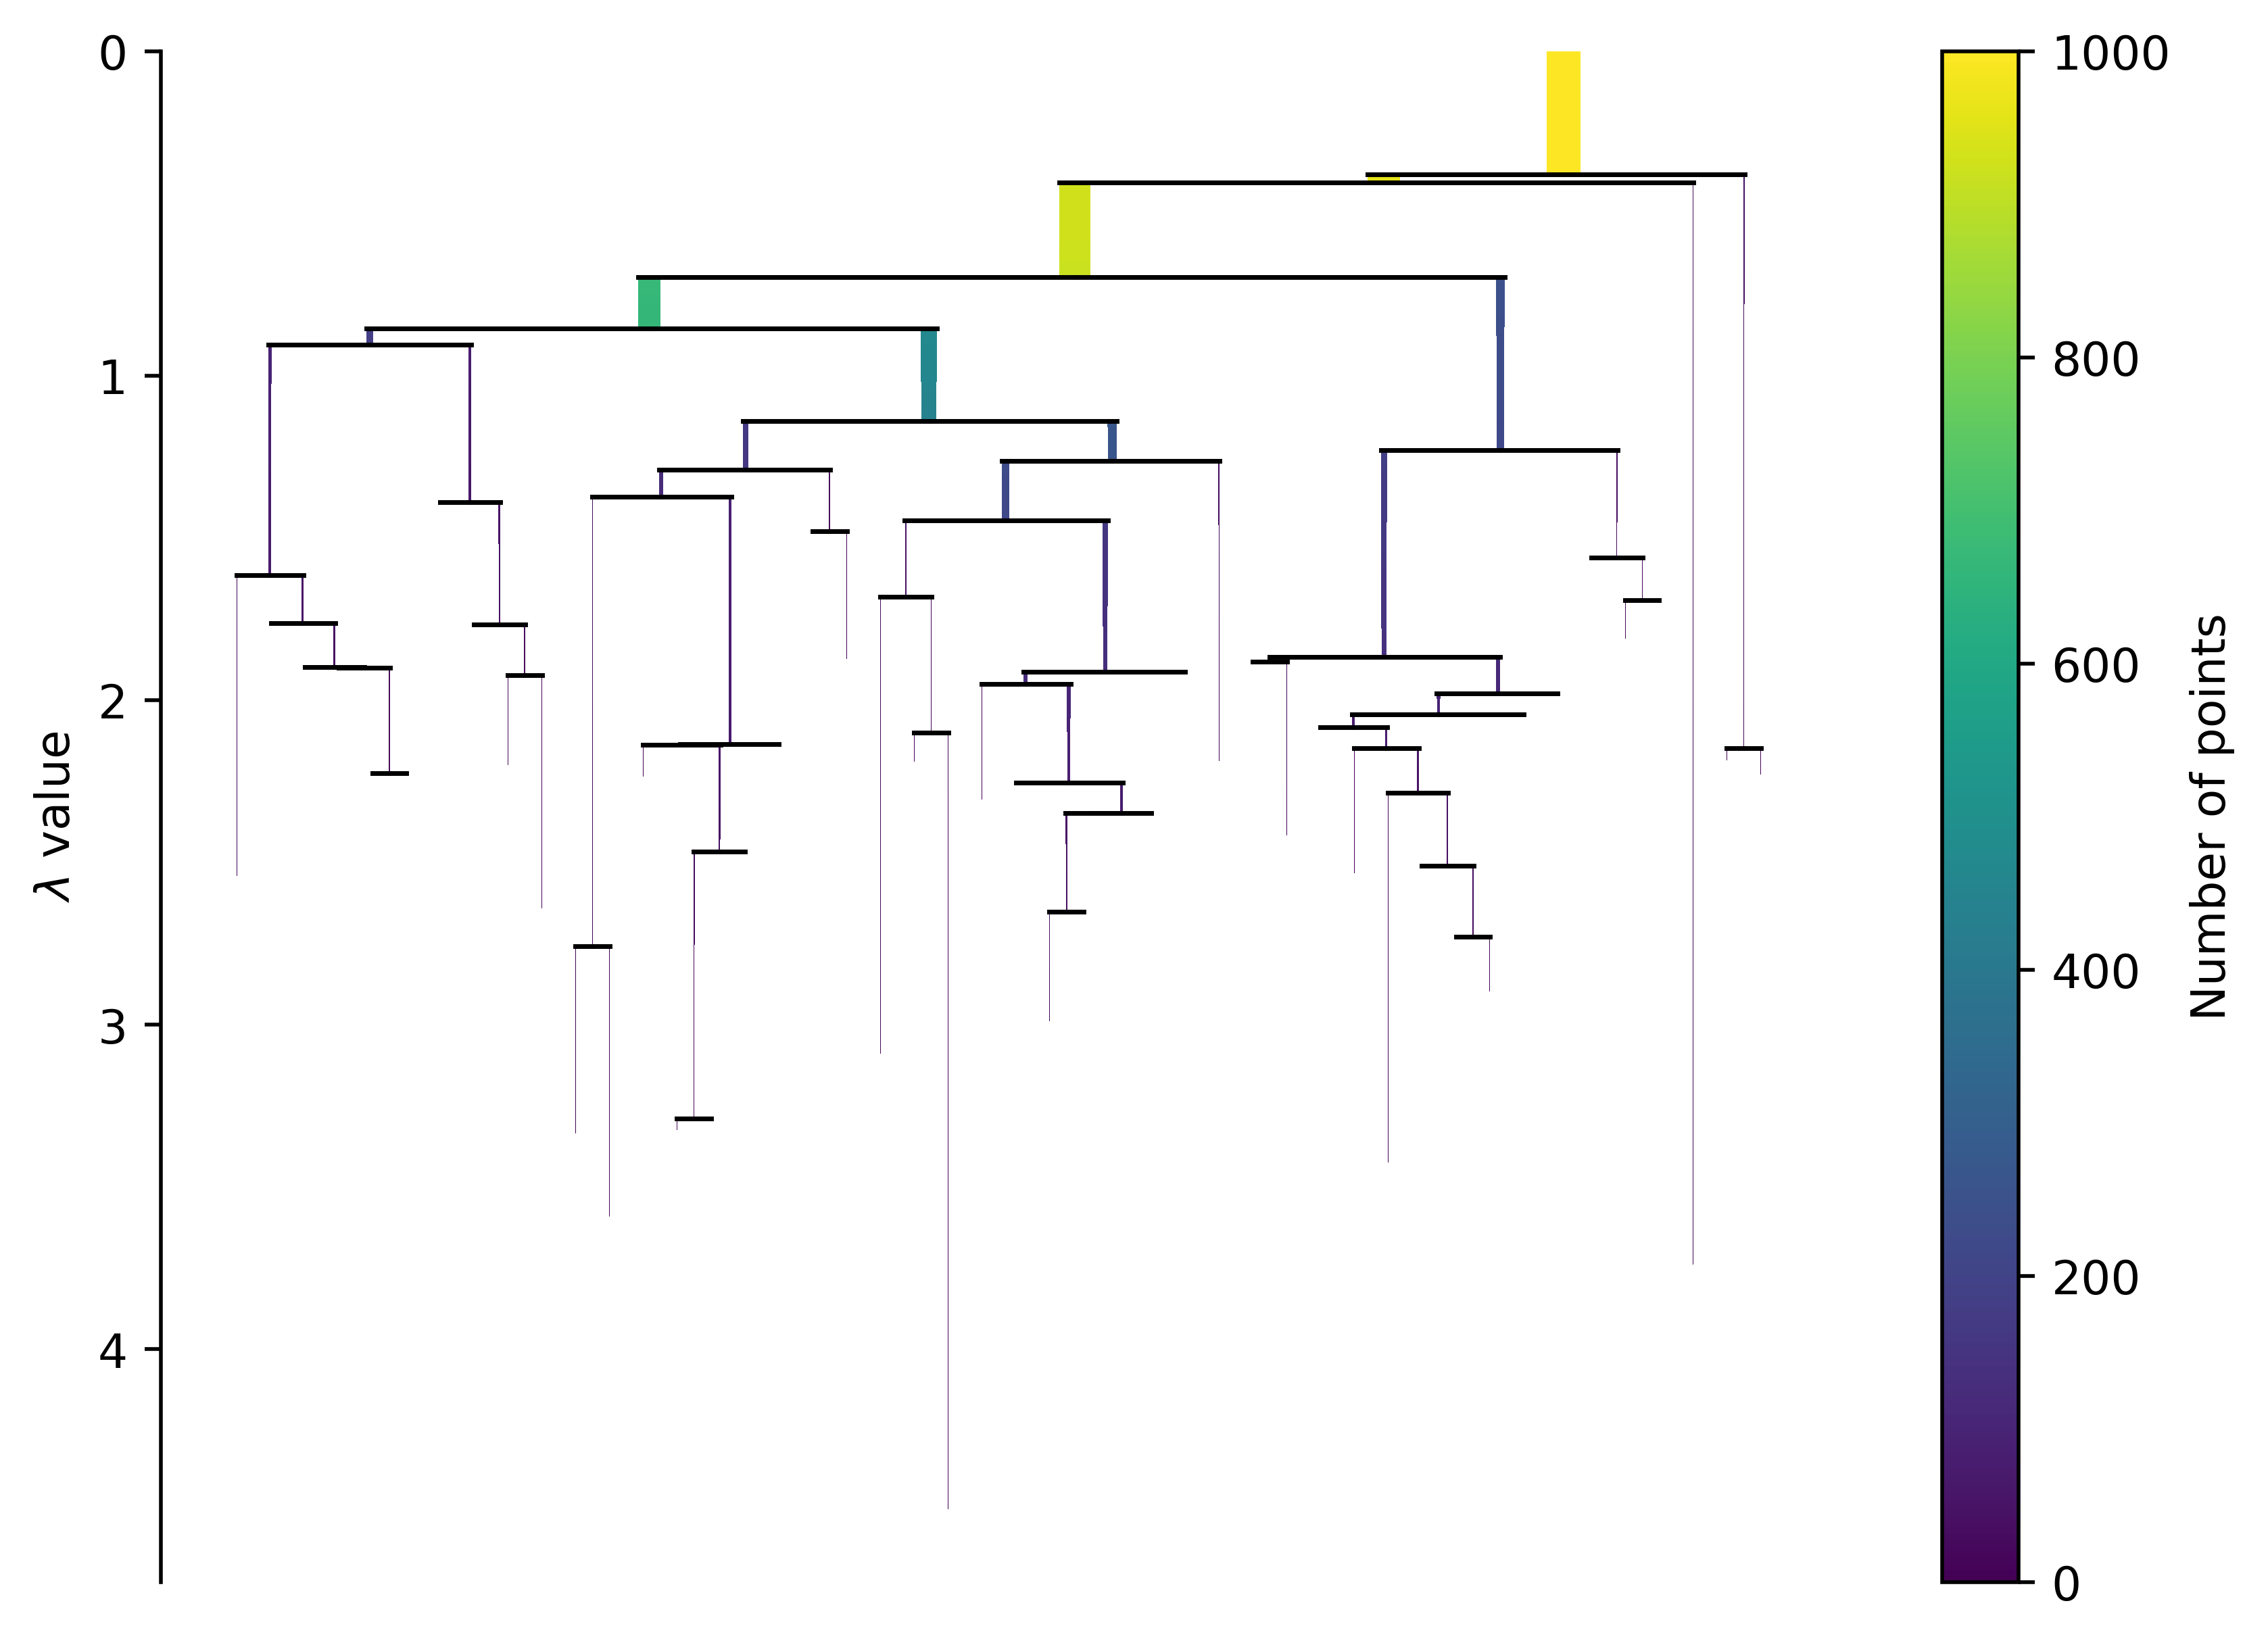

In [11]:
import seaborn as sns
plt.figure(figsize=(8, 6), dpi= 500, facecolor='w', edgecolor='k')
model.condensed_tree_.plot()

# GNN Embedding

In [1]:
import sys
import torch
import cudf
from cuml.neighbors import NearestNeighbors
from cuml.datasets import make_blobs
import cupy as cp
from cuml.cluster import HDBSCAN, KMeans
import cuml
import matplotlib.pyplot as plt
sys.path.append('../..')
from LightningModules.GNNNodeEmbedding.Models.gnn_embedding import InteractionGNN
from LightningModules.GNNNodeEmbedding.utils import generate_toys
model = InteractionGNN.load_from_checkpoint("/global/cfs/cdirs/m3443/usr/ryanliu/ITk_gnn_embedding/ITk_barrel_gnn_embedding/nay5rxu1/checkpoints/last.ckpt").to("cuda")

In [4]:
event = generate_toys(100, 10, 1, 5, 2, 1000., 1.0, 0.5).cuda()

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/GNNNodeEmbedding/utils.py:266: RuntimeWarning: invalid value encountered in sqrt
  y = sign*(np.sqrt(r**2 - (x - r*np.cos(theta))**2) - r*np.sin(theta))


In [5]:
with torch.no_grad():
    embeddings = model(event.x, event.graph)

/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [8]:
HDBSCANmodel = HDBSCAN(min_cluster_size = 3, min_samples = 3, max_cluster_size=15, metric='euclidean', cluster_selection_method = "leaf", verbose = cuml.common.logger.level_critical)

In [9]:
clusters = cp.asnumpy(HDBSCANmodel.fit_predict(embeddings))

Label prop iterations: 11
Label prop iterations: 6
Label prop iterations: 3
Iterations: 3
62267,141,98,16,393,1050
Label prop iterations: 4
Label prop iterations: 3
Iterations: 2
576,83,68,9,112,309
Label prop iterations: 2
Iterations: 1
562,57,39,6,60,110


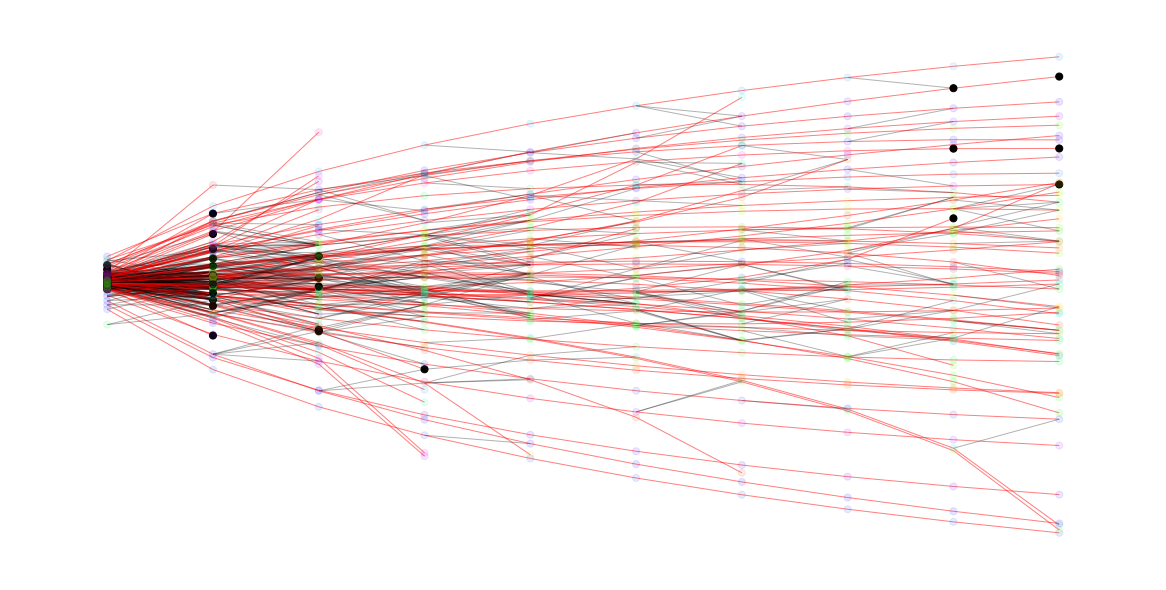

In [31]:
import networkx as nx
from matplotlib import cm
event = event.cpu().detach()
G = nx.Graph()
G.add_nodes_from(range(len(event.x)))

for i in range(len(event.graph.T)):
    color = [1, 0, 0, 0.5] if event.y[i] else [0, 0, 0, 0.3] 
    G.add_edge(*event.graph.T.tolist()[i], color = color)

pos = {}

for i in range(len(event.x)):
    pos[i] = event.x[i].numpy()
    
node_color = cm.gist_rainbow((clusters + 1)/(clusters + 1).max())
node_color[:, -1]=0.1
node_color[clusters == -1] = [0,0,0,1]

import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
nx.draw(G, pos=pos, node_size = 50, node_color = node_color, edge_color = nx.get_edge_attributes(G,'color').values())
plt.draw()

In [129]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
from torch import nn
from torch_scatter import scatter_mean, scatter_add, scatter_min

labels = torch.tensor(clusters+1).long()
labels = nn.functional.one_hot(labels, num_classes=labels.max()+1).float()
_, pid = event.pid.unique(return_inverse = True)
pid_cluster_counts = scatter_add(labels, pid, dim = 0, dim_size = pid.max()+1)
original_assignments = labels + 0.1*torch.rand(labels.shape)
_, pid = event.pid.unique(return_inverse = True)
bipartite_matrix = csr_matrix(scatter_add(original_assignments, pid, dim = 0, dim_size = pid.max()+1).cpu().numpy())
row_match, col_match = min_weight_full_bipartite_matching(bipartite_matrix, maximize=True)
pt = scatter_min(event.pt, pid, dim=0, dim_size = pid.max()+1)[0]

majority_mask = (pid_cluster_counts[row_match, col_match]/pid_cluster_counts[:, col_match].sum(0) > 0.5)
pt_mask = (pt[row_match] > 1000.)

eff = (majority_mask & pt_mask).sum()/(pt > 1000.).sum()
pur = (pid_cluster_counts[row_match, col_match]/pid_cluster_counts[:, col_match].sum(0))[majority_mask].mean()

In [130]:
print(eff, pur)

tensor(0.7895) tensor(0.9498)


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

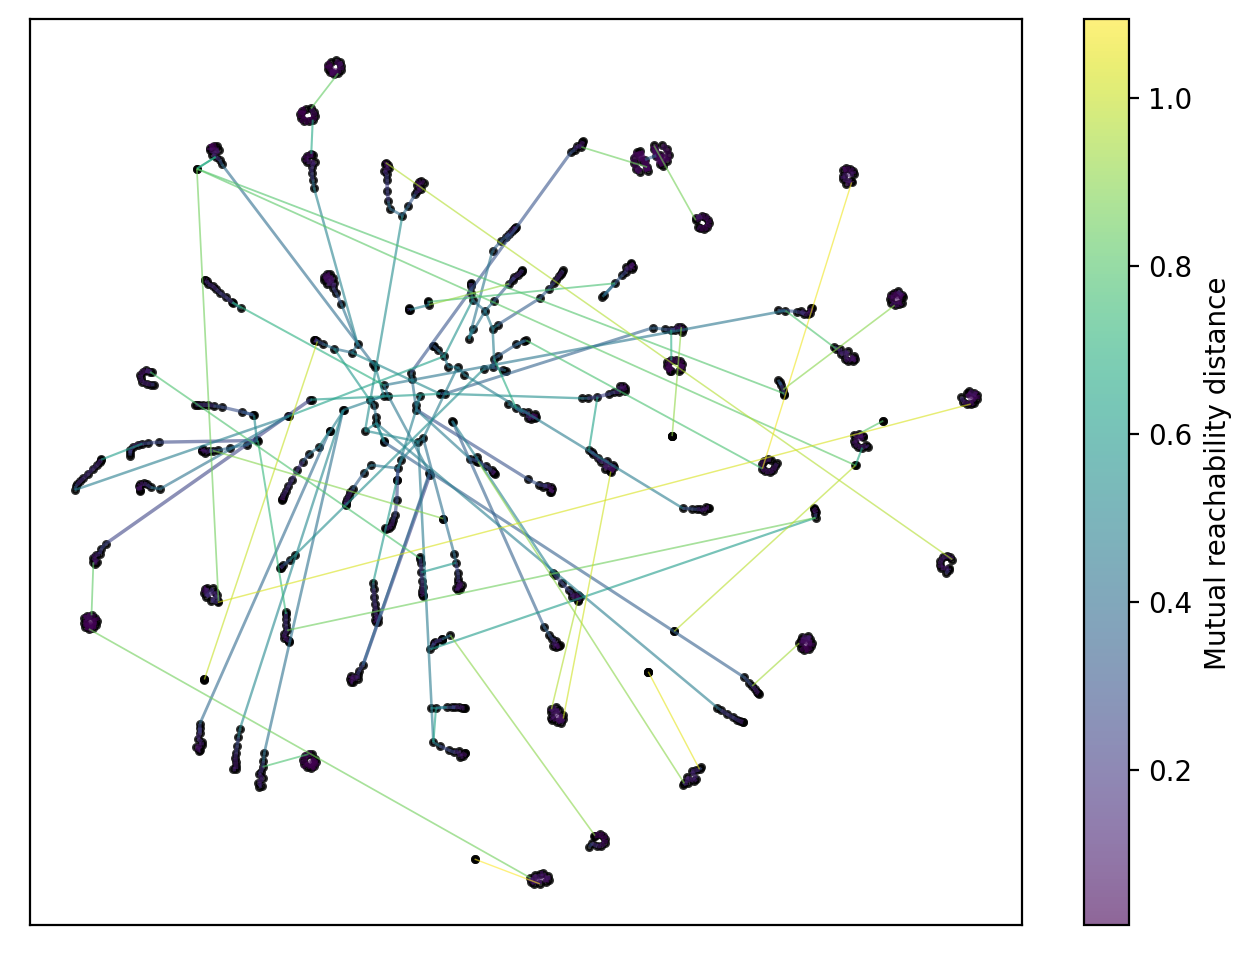

In [100]:
plt.figure(figsize=(8, 6), dpi= 200, facecolor='w', edgecolor='k')
HDBSCANmodel.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=5,
                                      edge_linewidth=0.5)

<AxesSubplot:ylabel='distance'>

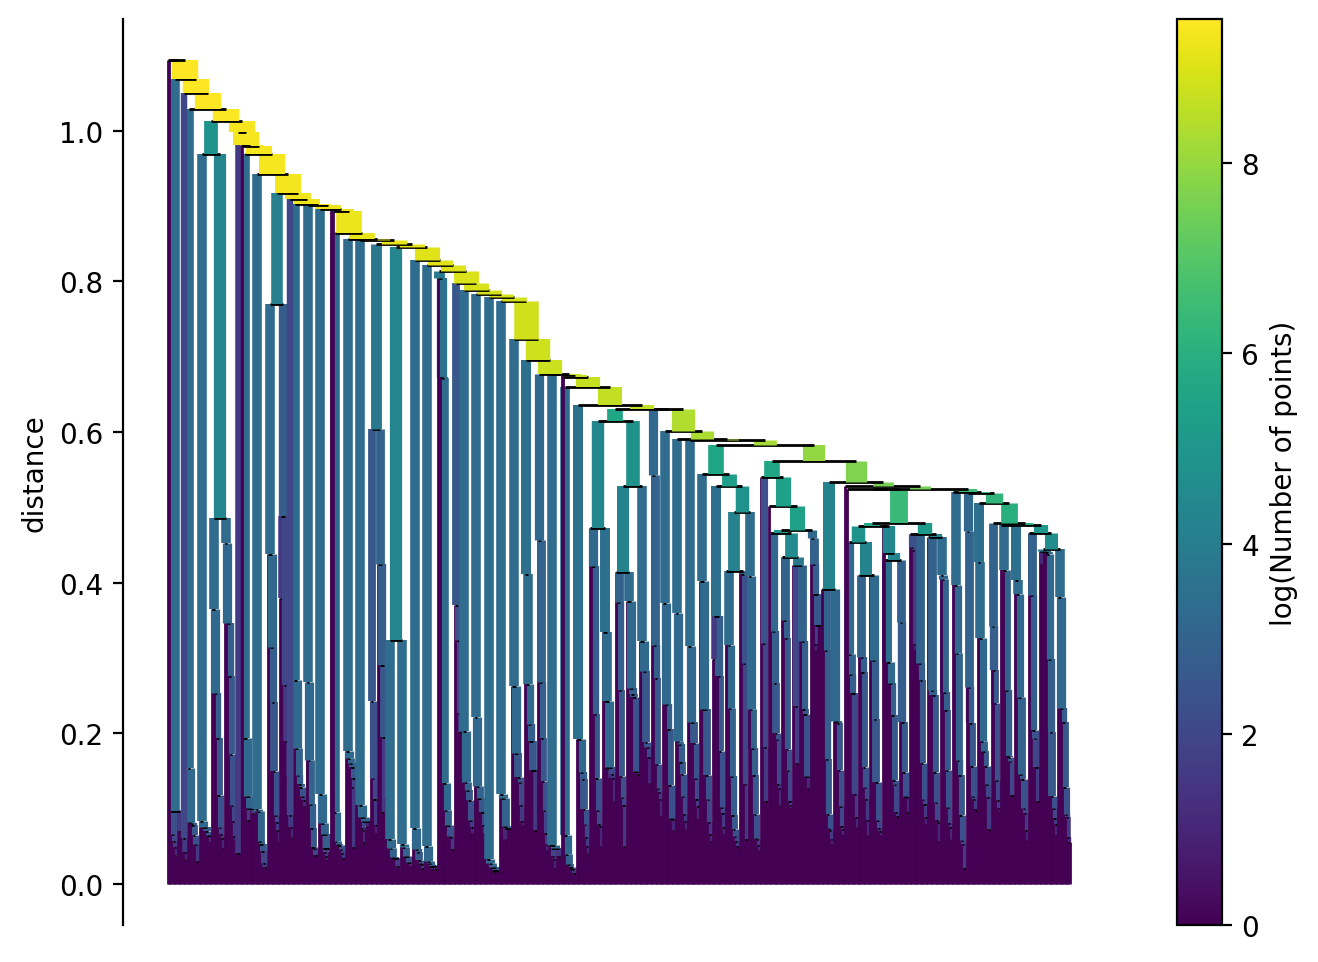

In [101]:
plt.figure(figsize=(8, 6), dpi= 200, facecolor='w', edgecolor='k')
HDBSCANmodel.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

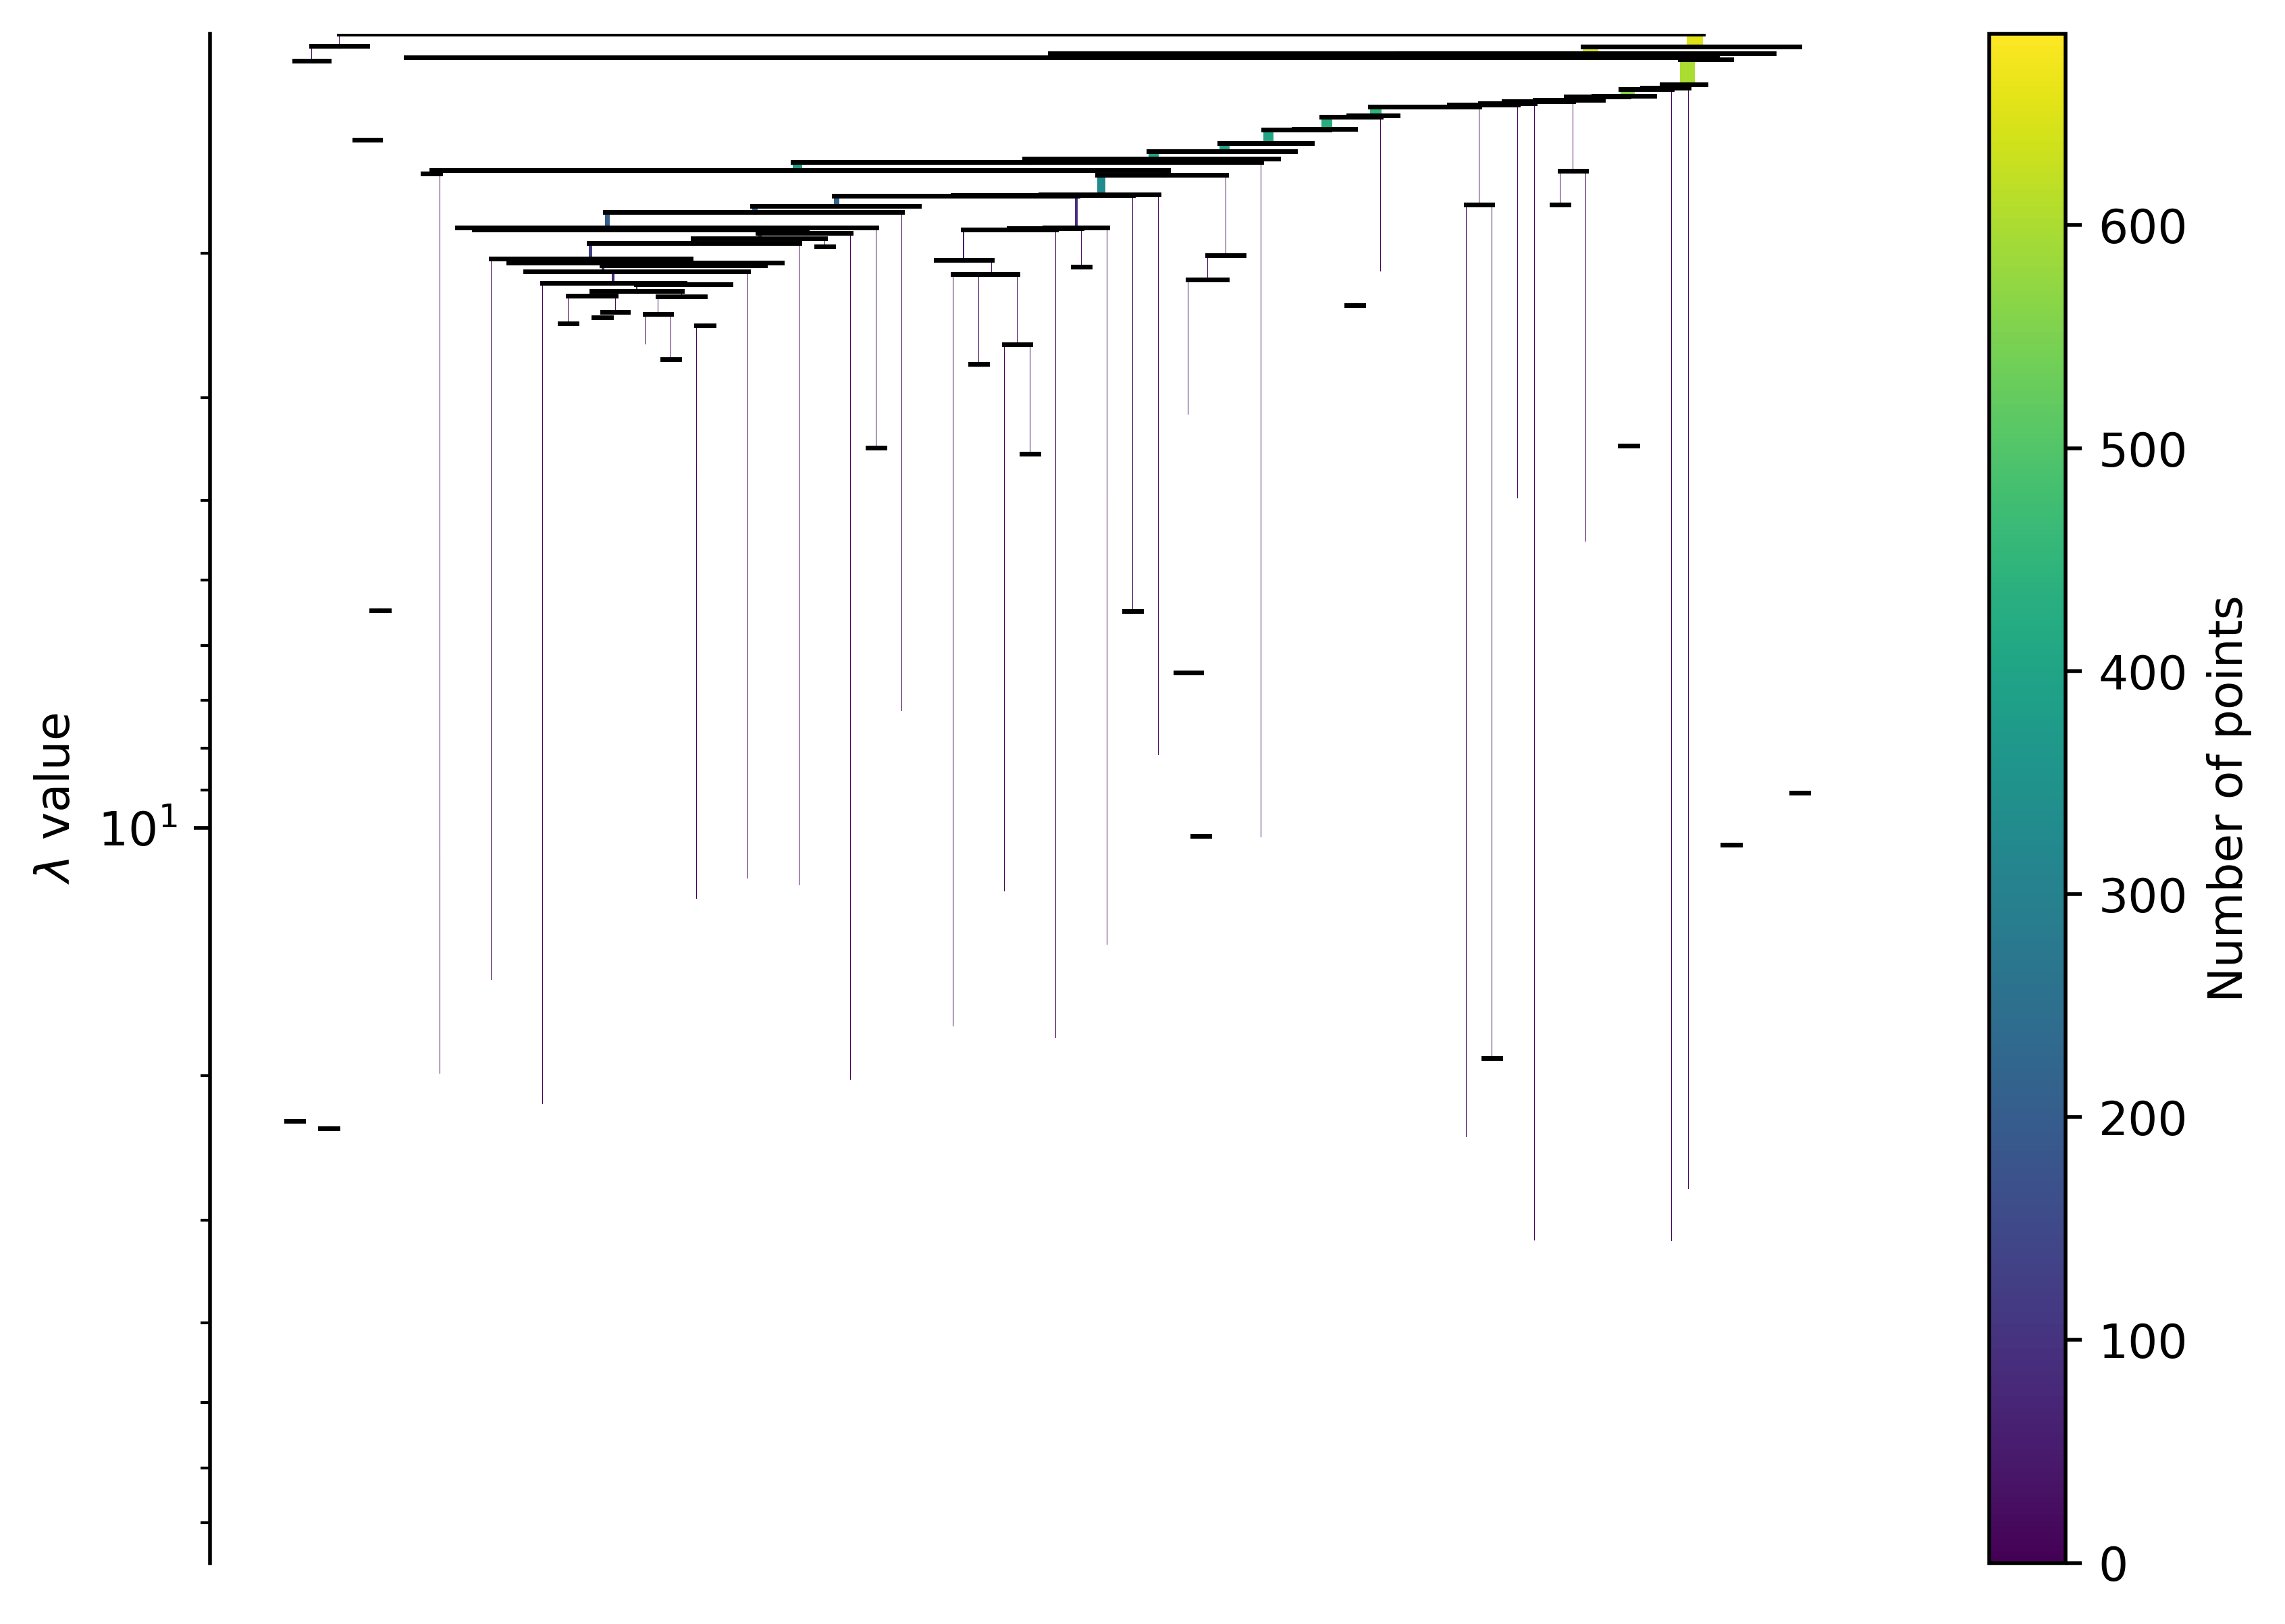

In [132]:
import seaborn as sns
plt.figure(figsize=(8, 6), dpi= 500, facecolor='w', edgecolor='k')
plt.yscale('log')
HDBSCANmodel.condensed_tree_.plot()

In [25]:
from cuml.cluster import KMeans

In [28]:
%%time
kmean = KMeans(handle=None, n_clusters=1000, max_iter=300, tol=0.0001, verbose=False, random_state=1, init='scalable-k-means++', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type=None)

CPU times: user 3.7 ms, sys: 33.5 ms, total: 37.2 ms
Wall time: 150 ms


# Torch Sparse

In [1]:
import torch

In [48]:
a = torch.arange(10).cuda()
b = torch.randperm(10).cuda()
inds = torch.stack([a, b], dim = 0)
values = torch.rand(10).cuda()
sparse_tensor = torch.sparse_coo_tensor(inds, values, (10, 10)).coalesce().requires_grad_(True)
sparse_tensor2 = torch.sparse_coo_tensor(inds, values, (10, 10)).coalesce().requires_grad_(True)

In [42]:
# sparse_tensor.requires_grad_(True)

In [57]:
a = torch.rand((10,10)).requires_grad_(True)
b = torch.randint(10, (10, 5))
torch.einsum("ij, ikj -> ik", a, a[b]).sum().backward()

In [44]:
tot.backward()

In [45]:
print(sparse_tensor.grad)
print(dense.grad)

tensor(indices=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                       [3, 4, 2, 0, 6, 9, 8, 7, 1, 5]]),
       values=tensor([3.2156, 4.5869, 5.2903, 5.0927, 3.7936, 4.7885, 5.3785,
                      6.7004, 5.1172, 5.4492]),
       device='cuda:0', size=(10, 10), nnz=10, layout=torch.sparse_coo)
None


In [1]:
import torch

In [2]:
a = torch.rand(10, 10)

In [5]:
a[torch.arange(10), torch.randperm(10)]

tensor([0.6529, 0.1740, 0.1730, 0.8830, 0.9523, 0.0704, 0.4337, 0.2480, 0.1564,
        0.5094])